In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
46,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
47,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
51,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
56,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
57,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

### Model in Keras

In [21]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 64
TRAIN_IMG_SIZE_WIDTH = 400

BATCH_SIZE = 12

NO_OF_CLASSES = 4

PATIENCE = 2
EPOCHS = 5


In [19]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V3_4(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 shear_range=0.0, zoom_range=0.0,
                 rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, 
                 horizontal_flip=False, vertical_flip=False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0,
                 shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.shuffle = shuffle
        self.datagen_img = ImageDataGenerator(samplewise_center=img_center, samplewise_std_normalization=img_standardize, 
                                          rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')

        self.datagen_mask = ImageDataGenerator(rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, 
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='bool')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if self.use_unsharp_mask:
                img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img

            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,(int(self.df['ClassId'].iloc[indexes[idx]]) - 1)] = mask
         
        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=self.batch_size, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=self.batch_size, shuffle=False)
        
        X_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        
        (X_list, y_list) = zip(image_generator, mask_generator).__next__()
        for i in range(len(X_list)):
            X_arg[i,] = X[i,]
            y_arg[i,:,:,:] = y[i,:,:,:]
            X_arg[i + self.batch_size] = X_list[i]
            y_arg[i + self.batch_size] = y_list[i]

        return X_arg, y_arg

In [11]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [12]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def advanced_unet_64x400_segmentation_model(input_shape=(64, 400, 3), num_classes=1):
    inputs = Input(shape=input_shape) # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0) # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1) # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2) # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3) # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 1), strides=(2, 1))(down4) # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up4 = UpSampling2D((2, 1))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4) # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3) # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1) # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0) # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [14]:
advanced_model = advanced_unet_64x400_segmentation_model(num_classes=4)
advanced_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 400, 3)   0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 64, 400, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 64, 400, 32)  128         conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 64, 400, 32)  0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv2d_30 

__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 2, 25, 1024)  4096        conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 2, 25, 1024)  0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
up_sampling2d_6 (UpSampling2D)  (None, 4, 25, 1024)  0           activation_39[0][0]              
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 4, 25, 1536)  0           activation_37[0][0]              
                                                                 up_sampling2d_6[0][0]            
__________________________________________________________________________________________________
conv2d_41 

__________________________________________________________________________________________________
activation_49 (Activation)      (None, 32, 200, 64)  0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 32, 200, 64)  36928       activation_49[0][0]              
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 32, 200, 64)  256         conv2d_51[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 32, 200, 64)  0           batch_normalization_50[0][0]     
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 200, 64)  36928       activation_50[0][0]              
__________

In [15]:
from keras.optimizers import RMSprop

advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [16]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss',
        min_delta = 0.005,
        patience=patient, 
        mode='min', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient//2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./unet_model_64x400_unsharp.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, LR]
    return [ES, MC, RR]


In [22]:
idx = int(0.8*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/5


132/473 [=======>......................] - ETA: 27:52 - loss: -0.4856 - dice_coeff: 0.2796 - acc: 0.08 - ETA: 26:45 - loss: -0.2539 - dice_coeff: 0.1649 - acc: 0.04 - ETA: 26:07 - loss: -0.2563 - dice_coeff: 0.1653 - acc: 0.04 - ETA: 25:42 - loss: -0.2874 - dice_coeff: 0.1793 - acc: 0.04 - ETA: 25:52 - loss: -0.2790 - dice_coeff: 0.1749 - acc: 0.04 - ETA: 25:56 - loss: -0.2805 - dice_coeff: 0.1760 - acc: 0.04 - ETA: 25:58 - loss: -0.2978 - dice_coeff: 0.1838 - acc: 0.04 - ETA: 25:56 - loss: -0.3028 - dice_coeff: 0.1859 - acc: 0.04 - ETA: 25:58 - loss: -0.3257 - dice_coeff: 0.1971 - acc: 0.04 - ETA: 25:58 - loss: -0.3189 - dice_coeff: 0.1937 - acc: 0.04 - ETA: 25:54 - loss: -0.3127 - dice_coeff: 0.1901 - acc: 0.04 - ETA: 25:17 - loss: -0.3093 - dice_coeff: 0.1878 - acc: 0.04 - ETA: 24:43 - loss: -0.3290 - dice_coeff: 0.1974 - acc: 0.04 - ETA: 24:13 - loss: -0.3308 - dice_coeff: 0.1981 - acc: 0.04 - ETA: 23:49 - loss: -0.3341 - dice_coeff: 0.1996 - acc: 0.04 - ETA: 23:30 - loss: -0.3321 

264/473 [===============>..............] - ETA: 13:29 - loss: -0.4070 - dice_coeff: 0.2305 - acc: 0.04 - ETA: 13:26 - loss: -0.4082 - dice_coeff: 0.2311 - acc: 0.04 - ETA: 13:24 - loss: -0.4068 - dice_coeff: 0.2304 - acc: 0.04 - ETA: 13:21 - loss: -0.4067 - dice_coeff: 0.2302 - acc: 0.04 - ETA: 13:19 - loss: -0.4062 - dice_coeff: 0.2299 - acc: 0.04 - ETA: 13:16 - loss: -0.4057 - dice_coeff: 0.2297 - acc: 0.04 - ETA: 13:13 - loss: -0.4074 - dice_coeff: 0.2304 - acc: 0.04 - ETA: 13:11 - loss: -0.4070 - dice_coeff: 0.2302 - acc: 0.04 - ETA: 13:08 - loss: -0.4067 - dice_coeff: 0.2300 - acc: 0.04 - ETA: 13:05 - loss: -0.4068 - dice_coeff: 0.2300 - acc: 0.04 - ETA: 13:03 - loss: -0.4072 - dice_coeff: 0.2302 - acc: 0.04 - ETA: 13:00 - loss: -0.4085 - dice_coeff: 0.2309 - acc: 0.04 - ETA: 12:58 - loss: -0.4082 - dice_coeff: 0.2307 - acc: 0.04 - ETA: 12:55 - loss: -0.4092 - dice_coeff: 0.2312 - acc: 0.04 - ETA: 12:53 - loss: -0.4106 - dice_coeff: 0.2318 - acc: 0.04 - ETA: 12:50 - loss: -0.4099 

396/473 [========================>.....] - ETA: 8:03 - loss: -0.4894 - dice_coeff: 0.2683 - acc: 0.040 - ETA: 8:01 - loss: -0.4904 - dice_coeff: 0.2687 - acc: 0.040 - ETA: 7:58 - loss: -0.4905 - dice_coeff: 0.2688 - acc: 0.040 - ETA: 7:56 - loss: -0.4908 - dice_coeff: 0.2689 - acc: 0.040 - ETA: 7:54 - loss: -0.4900 - dice_coeff: 0.2685 - acc: 0.040 - ETA: 7:51 - loss: -0.4900 - dice_coeff: 0.2685 - acc: 0.040 - ETA: 7:49 - loss: -0.4911 - dice_coeff: 0.2690 - acc: 0.040 - ETA: 7:47 - loss: -0.4922 - dice_coeff: 0.2696 - acc: 0.040 - ETA: 7:44 - loss: -0.4917 - dice_coeff: 0.2693 - acc: 0.040 - ETA: 7:42 - loss: -0.4921 - dice_coeff: 0.2695 - acc: 0.040 - ETA: 7:39 - loss: -0.4926 - dice_coeff: 0.2697 - acc: 0.040 - ETA: 7:37 - loss: -0.4939 - dice_coeff: 0.2704 - acc: 0.040 - ETA: 7:35 - loss: -0.4943 - dice_coeff: 0.2706 - acc: 0.040 - ETA: 7:32 - loss: -0.4951 - dice_coeff: 0.2709 - acc: 0.040 - ETA: 7:30 - loss: -0.4963 - dice_coeff: 0.2716 - acc: 0.040 - ETA: 7:28 - loss: -0.4962 -

473/473 [==============================] - ETA: 2:55 - loss: -0.5655 - dice_coeff: 0.3046 - acc: 0.040 - ETA: 2:52 - loss: -0.5660 - dice_coeff: 0.3048 - acc: 0.040 - ETA: 2:50 - loss: -0.5670 - dice_coeff: 0.3053 - acc: 0.040 - ETA: 2:48 - loss: -0.5674 - dice_coeff: 0.3055 - acc: 0.040 - ETA: 2:45 - loss: -0.5684 - dice_coeff: 0.3060 - acc: 0.040 - ETA: 2:43 - loss: -0.5698 - dice_coeff: 0.3066 - acc: 0.040 - ETA: 2:41 - loss: -0.5691 - dice_coeff: 0.3063 - acc: 0.040 - ETA: 2:38 - loss: -0.5696 - dice_coeff: 0.3065 - acc: 0.040 - ETA: 2:36 - loss: -0.5709 - dice_coeff: 0.3072 - acc: 0.040 - ETA: 2:34 - loss: -0.5710 - dice_coeff: 0.3072 - acc: 0.040 - ETA: 2:31 - loss: -0.5708 - dice_coeff: 0.3071 - acc: 0.040 - ETA: 2:29 - loss: -0.5721 - dice_coeff: 0.3078 - acc: 0.040 - ETA: 2:27 - loss: -0.5733 - dice_coeff: 0.3083 - acc: 0.040 - ETA: 2:25 - loss: -0.5743 - dice_coeff: 0.3088 - acc: 0.040 - ETA: 2:22 - loss: -0.5752 - dice_coeff: 0.3093 - acc: 0.040 - ETA: 2:20 - loss: -0.5748 -

132/473 [=======>......................] - ETA: 3:16 - loss: -0.5023 - dice_coeff: 0.2717 - acc: 0.023 - ETA: 3:12 - loss: -0.7038 - dice_coeff: 0.3717 - acc: 0.034 - ETA: 3:13 - loss: -0.7534 - dice_coeff: 0.3969 - acc: 0.044 - ETA: 3:11 - loss: -0.8586 - dice_coeff: 0.4482 - acc: 0.050 - ETA: 3:10 - loss: -0.8351 - dice_coeff: 0.4364 - acc: 0.046 - ETA: 3:10 - loss: -0.8003 - dice_coeff: 0.4192 - acc: 0.043 - ETA: 3:08 - loss: -0.8385 - dice_coeff: 0.4377 - acc: 0.044 - ETA: 3:09 - loss: -0.8050 - dice_coeff: 0.4210 - acc: 0.041 - ETA: 3:08 - loss: -0.8052 - dice_coeff: 0.4229 - acc: 0.046 - ETA: 3:08 - loss: -0.7950 - dice_coeff: 0.4177 - acc: 0.045 - ETA: 3:08 - loss: -0.7891 - dice_coeff: 0.4146 - acc: 0.044 - ETA: 3:08 - loss: -0.8034 - dice_coeff: 0.4210 - acc: 0.043 - ETA: 4:08 - loss: -0.7913 - dice_coeff: 0.4157 - acc: 0.044 - ETA: 5:34 - loss: -0.8231 - dice_coeff: 0.4312 - acc: 0.046 - ETA: 6:49 - loss: -0.8196 - dice_coeff: 0.4290 - acc: 0.044 - ETA: 7:57 - loss: -0.8337 -

264/473 [===============>..............] - ETA: 12:14 - loss: -0.8732 - dice_coeff: 0.4535 - acc: 0.03 - ETA: 12:12 - loss: -0.8717 - dice_coeff: 0.4527 - acc: 0.03 - ETA: 12:10 - loss: -0.8702 - dice_coeff: 0.4519 - acc: 0.03 - ETA: 12:08 - loss: -0.8705 - dice_coeff: 0.4521 - acc: 0.03 - ETA: 12:07 - loss: -0.8702 - dice_coeff: 0.4520 - acc: 0.03 - ETA: 12:05 - loss: -0.8704 - dice_coeff: 0.4521 - acc: 0.03 - ETA: 12:03 - loss: -0.8732 - dice_coeff: 0.4535 - acc: 0.04 - ETA: 12:01 - loss: -0.8718 - dice_coeff: 0.4528 - acc: 0.03 - ETA: 11:59 - loss: -0.8703 - dice_coeff: 0.4521 - acc: 0.03 - ETA: 11:57 - loss: -0.8704 - dice_coeff: 0.4521 - acc: 0.03 - ETA: 11:55 - loss: -0.8718 - dice_coeff: 0.4528 - acc: 0.03 - ETA: 11:53 - loss: -0.8710 - dice_coeff: 0.4524 - acc: 0.03 - ETA: 11:51 - loss: -0.8716 - dice_coeff: 0.4527 - acc: 0.03 - ETA: 11:49 - loss: -0.8750 - dice_coeff: 0.4544 - acc: 0.04 - ETA: 11:47 - loss: -0.8733 - dice_coeff: 0.4535 - acc: 0.03 - ETA: 11:45 - loss: -0.8717 

396/473 [========================>.....] - ETA: 7:41 - loss: -0.9165 - dice_coeff: 0.4751 - acc: 0.040 - ETA: 7:39 - loss: -0.9165 - dice_coeff: 0.4751 - acc: 0.040 - ETA: 7:37 - loss: -0.9176 - dice_coeff: 0.4756 - acc: 0.040 - ETA: 7:34 - loss: -0.9186 - dice_coeff: 0.4761 - acc: 0.040 - ETA: 7:32 - loss: -0.9194 - dice_coeff: 0.4765 - acc: 0.040 - ETA: 7:30 - loss: -0.9194 - dice_coeff: 0.4765 - acc: 0.040 - ETA: 7:28 - loss: -0.9187 - dice_coeff: 0.4761 - acc: 0.040 - ETA: 7:26 - loss: -0.9185 - dice_coeff: 0.4760 - acc: 0.040 - ETA: 7:23 - loss: -0.9198 - dice_coeff: 0.4767 - acc: 0.040 - ETA: 7:21 - loss: -0.9206 - dice_coeff: 0.4771 - acc: 0.040 - ETA: 7:19 - loss: -0.9211 - dice_coeff: 0.4774 - acc: 0.040 - ETA: 7:17 - loss: -0.9208 - dice_coeff: 0.4772 - acc: 0.040 - ETA: 7:15 - loss: -0.9220 - dice_coeff: 0.4778 - acc: 0.040 - ETA: 7:12 - loss: -0.9222 - dice_coeff: 0.4779 - acc: 0.040 - ETA: 7:10 - loss: -0.9231 - dice_coeff: 0.4783 - acc: 0.040 - ETA: 7:08 - loss: -0.9236 -

473/473 [==============================] - ETA: 2:49 - loss: -0.9436 - dice_coeff: 0.4889 - acc: 0.041 - ETA: 2:47 - loss: -0.9441 - dice_coeff: 0.4892 - acc: 0.041 - ETA: 2:45 - loss: -0.9447 - dice_coeff: 0.4894 - acc: 0.041 - ETA: 2:43 - loss: -0.9445 - dice_coeff: 0.4893 - acc: 0.041 - ETA: 2:40 - loss: -0.9442 - dice_coeff: 0.4892 - acc: 0.041 - ETA: 2:38 - loss: -0.9449 - dice_coeff: 0.4896 - acc: 0.041 - ETA: 2:36 - loss: -0.9449 - dice_coeff: 0.4896 - acc: 0.041 - ETA: 2:34 - loss: -0.9453 - dice_coeff: 0.4897 - acc: 0.041 - ETA: 2:31 - loss: -0.9461 - dice_coeff: 0.4901 - acc: 0.041 - ETA: 2:29 - loss: -0.9470 - dice_coeff: 0.4905 - acc: 0.041 - ETA: 2:27 - loss: -0.9476 - dice_coeff: 0.4909 - acc: 0.041 - ETA: 2:25 - loss: -0.9483 - dice_coeff: 0.4912 - acc: 0.041 - ETA: 2:23 - loss: -0.9490 - dice_coeff: 0.4915 - acc: 0.041 - ETA: 2:20 - loss: -0.9488 - dice_coeff: 0.4914 - acc: 0.041 - ETA: 2:18 - loss: -0.9485 - dice_coeff: 0.4913 - acc: 0.041 - ETA: 2:16 - loss: -0.9497 -

132/473 [=======>......................] - ETA: 3:07 - loss: -0.7161 - dice_coeff: 0.3813 - acc: 0.033 - ETA: 3:10 - loss: -0.7902 - dice_coeff: 0.4117 - acc: 0.023 - ETA: 3:09 - loss: -0.7274 - dice_coeff: 0.3819 - acc: 0.025 - ETA: 3:08 - loss: -0.7543 - dice_coeff: 0.3962 - acc: 0.030 - ETA: 3:08 - loss: -0.8656 - dice_coeff: 0.4518 - acc: 0.039 - ETA: 3:08 - loss: -0.9340 - dice_coeff: 0.4869 - acc: 0.047 - ETA: 3:09 - loss: -0.8767 - dice_coeff: 0.4603 - acc: 0.046 - ETA: 3:07 - loss: -0.8561 - dice_coeff: 0.4534 - acc: 0.049 - ETA: 3:07 - loss: -0.8381 - dice_coeff: 0.4444 - acc: 0.048 - ETA: 3:07 - loss: -0.7953 - dice_coeff: 0.4228 - acc: 0.044 - ETA: 3:06 - loss: -0.7808 - dice_coeff: 0.4150 - acc: 0.042 - ETA: 3:05 - loss: -0.8122 - dice_coeff: 0.4294 - acc: 0.041 - ETA: 4:14 - loss: -0.8240 - dice_coeff: 0.4347 - acc: 0.041 - ETA: 5:40 - loss: -0.8232 - dice_coeff: 0.4338 - acc: 0.040 - ETA: 6:51 - loss: -0.7972 - dice_coeff: 0.4205 - acc: 0.039 - ETA: 7:55 - loss: -0.7933 -

264/473 [===============>..............] - ETA: 12:14 - loss: -0.9932 - dice_coeff: 0.5154 - acc: 0.04 - ETA: 12:12 - loss: -0.9919 - dice_coeff: 0.5149 - acc: 0.04 - ETA: 12:10 - loss: -0.9928 - dice_coeff: 0.5153 - acc: 0.04 - ETA: 12:08 - loss: -0.9959 - dice_coeff: 0.5168 - acc: 0.04 - ETA: 12:06 - loss: -0.9943 - dice_coeff: 0.5160 - acc: 0.04 - ETA: 12:05 - loss: -0.9965 - dice_coeff: 0.5171 - acc: 0.04 - ETA: 12:03 - loss: -0.9981 - dice_coeff: 0.5179 - acc: 0.04 - ETA: 12:01 - loss: -1.0001 - dice_coeff: 0.5188 - acc: 0.04 - ETA: 11:59 - loss: -1.0000 - dice_coeff: 0.5188 - acc: 0.04 - ETA: 11:57 - loss: -1.0005 - dice_coeff: 0.5190 - acc: 0.04 - ETA: 11:55 - loss: -0.9974 - dice_coeff: 0.5175 - acc: 0.04 - ETA: 11:53 - loss: -0.9984 - dice_coeff: 0.5179 - acc: 0.04 - ETA: 11:51 - loss: -0.9963 - dice_coeff: 0.5168 - acc: 0.04 - ETA: 11:48 - loss: -0.9943 - dice_coeff: 0.5159 - acc: 0.04 - ETA: 11:46 - loss: -0.9953 - dice_coeff: 0.5163 - acc: 0.04 - ETA: 11:44 - loss: -0.9958 

396/473 [========================>.....] - ETA: 7:41 - loss: -1.0159 - dice_coeff: 0.5265 - acc: 0.049 - ETA: 7:39 - loss: -1.0172 - dice_coeff: 0.5271 - acc: 0.049 - ETA: 7:37 - loss: -1.0180 - dice_coeff: 0.5275 - acc: 0.049 - ETA: 7:34 - loss: -1.0187 - dice_coeff: 0.5278 - acc: 0.049 - ETA: 7:32 - loss: -1.0193 - dice_coeff: 0.5281 - acc: 0.049 - ETA: 7:30 - loss: -1.0205 - dice_coeff: 0.5286 - acc: 0.049 - ETA: 7:28 - loss: -1.0189 - dice_coeff: 0.5279 - acc: 0.049 - ETA: 7:26 - loss: -1.0199 - dice_coeff: 0.5284 - acc: 0.049 - ETA: 7:23 - loss: -1.0197 - dice_coeff: 0.5282 - acc: 0.049 - ETA: 7:21 - loss: -1.0190 - dice_coeff: 0.5279 - acc: 0.049 - ETA: 7:19 - loss: -1.0188 - dice_coeff: 0.5279 - acc: 0.049 - ETA: 7:17 - loss: -1.0204 - dice_coeff: 0.5286 - acc: 0.049 - ETA: 7:15 - loss: -1.0185 - dice_coeff: 0.5277 - acc: 0.049 - ETA: 7:13 - loss: -1.0195 - dice_coeff: 0.5282 - acc: 0.049 - ETA: 7:10 - loss: -1.0197 - dice_coeff: 0.5283 - acc: 0.049 - ETA: 7:08 - loss: -1.0206 -

473/473 [==============================] - ETA: 2:50 - loss: -1.0270 - dice_coeff: 0.5318 - acc: 0.049 - ETA: 2:47 - loss: -1.0279 - dice_coeff: 0.5323 - acc: 0.049 - ETA: 2:45 - loss: -1.0283 - dice_coeff: 0.5325 - acc: 0.049 - ETA: 2:43 - loss: -1.0288 - dice_coeff: 0.5327 - acc: 0.049 - ETA: 2:41 - loss: -1.0298 - dice_coeff: 0.5332 - acc: 0.049 - ETA: 2:39 - loss: -1.0293 - dice_coeff: 0.5329 - acc: 0.049 - ETA: 2:36 - loss: -1.0285 - dice_coeff: 0.5325 - acc: 0.049 - ETA: 2:34 - loss: -1.0287 - dice_coeff: 0.5326 - acc: 0.049 - ETA: 2:32 - loss: -1.0289 - dice_coeff: 0.5327 - acc: 0.049 - ETA: 2:30 - loss: -1.0285 - dice_coeff: 0.5325 - acc: 0.049 - ETA: 2:27 - loss: -1.0289 - dice_coeff: 0.5327 - acc: 0.049 - ETA: 2:25 - loss: -1.0291 - dice_coeff: 0.5329 - acc: 0.049 - ETA: 2:23 - loss: -1.0288 - dice_coeff: 0.5327 - acc: 0.049 - ETA: 2:21 - loss: -1.0290 - dice_coeff: 0.5329 - acc: 0.049 - ETA: 2:18 - loss: -1.0288 - dice_coeff: 0.5328 - acc: 0.049 - ETA: 2:16 - loss: -1.0295 -

132/473 [=======>......................] - ETA: 3:05 - loss: -1.2741 - dice_coeff: 0.6454 - acc: 0.033 - ETA: 3:06 - loss: -1.2120 - dice_coeff: 0.6183 - acc: 0.043 - ETA: 3:06 - loss: -1.2113 - dice_coeff: 0.6186 - acc: 0.047 - ETA: 3:08 - loss: -1.1459 - dice_coeff: 0.5866 - acc: 0.043 - ETA: 3:07 - loss: -1.1337 - dice_coeff: 0.5806 - acc: 0.042 - ETA: 3:07 - loss: -1.1256 - dice_coeff: 0.5777 - acc: 0.046 - ETA: 3:07 - loss: -1.0883 - dice_coeff: 0.5608 - acc: 0.047 - ETA: 3:06 - loss: -1.0656 - dice_coeff: 0.5488 - acc: 0.044 - ETA: 3:05 - loss: -1.0857 - dice_coeff: 0.5586 - acc: 0.044 - ETA: 3:05 - loss: -1.0994 - dice_coeff: 0.5648 - acc: 0.042 - ETA: 3:05 - loss: -1.1124 - dice_coeff: 0.5712 - acc: 0.042 - ETA: 3:05 - loss: -1.0778 - dice_coeff: 0.5542 - acc: 0.041 - ETA: 4:09 - loss: -1.0511 - dice_coeff: 0.5409 - acc: 0.040 - ETA: 5:40 - loss: -1.0683 - dice_coeff: 0.5495 - acc: 0.041 - ETA: 6:54 - loss: -1.0601 - dice_coeff: 0.5463 - acc: 0.042 - ETA: 7:58 - loss: -1.0520 -

264/473 [===============>..............] - ETA: 12:17 - loss: -1.0613 - dice_coeff: 0.5484 - acc: 0.04 - ETA: 12:15 - loss: -1.0636 - dice_coeff: 0.5495 - acc: 0.04 - ETA: 12:13 - loss: -1.0650 - dice_coeff: 0.5502 - acc: 0.04 - ETA: 12:11 - loss: -1.0645 - dice_coeff: 0.5500 - acc: 0.04 - ETA: 12:10 - loss: -1.0603 - dice_coeff: 0.5480 - acc: 0.04 - ETA: 12:08 - loss: -1.0597 - dice_coeff: 0.5477 - acc: 0.04 - ETA: 12:06 - loss: -1.0600 - dice_coeff: 0.5479 - acc: 0.04 - ETA: 12:04 - loss: -1.0596 - dice_coeff: 0.5476 - acc: 0.04 - ETA: 12:02 - loss: -1.0601 - dice_coeff: 0.5479 - acc: 0.04 - ETA: 12:00 - loss: -1.0571 - dice_coeff: 0.5465 - acc: 0.04 - ETA: 11:59 - loss: -1.0590 - dice_coeff: 0.5473 - acc: 0.04 - ETA: 11:57 - loss: -1.0591 - dice_coeff: 0.5474 - acc: 0.04 - ETA: 11:55 - loss: -1.0587 - dice_coeff: 0.5474 - acc: 0.04 - ETA: 11:53 - loss: -1.0590 - dice_coeff: 0.5476 - acc: 0.04 - ETA: 11:51 - loss: -1.0595 - dice_coeff: 0.5478 - acc: 0.04 - ETA: 11:49 - loss: -1.0573 

396/473 [========================>.....] - ETA: 7:41 - loss: -1.0641 - dice_coeff: 0.5502 - acc: 0.051 - ETA: 7:39 - loss: -1.0646 - dice_coeff: 0.5505 - acc: 0.051 - ETA: 7:37 - loss: -1.0650 - dice_coeff: 0.5506 - acc: 0.051 - ETA: 7:35 - loss: -1.0649 - dice_coeff: 0.5506 - acc: 0.050 - ETA: 7:33 - loss: -1.0638 - dice_coeff: 0.5501 - acc: 0.050 - ETA: 7:30 - loss: -1.0637 - dice_coeff: 0.5500 - acc: 0.050 - ETA: 7:28 - loss: -1.0647 - dice_coeff: 0.5505 - acc: 0.050 - ETA: 7:26 - loss: -1.0647 - dice_coeff: 0.5505 - acc: 0.050 - ETA: 7:24 - loss: -1.0652 - dice_coeff: 0.5507 - acc: 0.050 - ETA: 7:22 - loss: -1.0656 - dice_coeff: 0.5509 - acc: 0.050 - ETA: 7:19 - loss: -1.0672 - dice_coeff: 0.5517 - acc: 0.050 - ETA: 7:17 - loss: -1.0680 - dice_coeff: 0.5521 - acc: 0.051 - ETA: 7:15 - loss: -1.0694 - dice_coeff: 0.5528 - acc: 0.051 - ETA: 7:13 - loss: -1.0707 - dice_coeff: 0.5534 - acc: 0.051 - ETA: 7:11 - loss: -1.0694 - dice_coeff: 0.5528 - acc: 0.051 - ETA: 7:09 - loss: -1.0688 -

473/473 [==============================] - ETA: 2:49 - loss: -1.0731 - dice_coeff: 0.5544 - acc: 0.050 - ETA: 2:47 - loss: -1.0736 - dice_coeff: 0.5547 - acc: 0.050 - ETA: 2:45 - loss: -1.0740 - dice_coeff: 0.5550 - acc: 0.050 - ETA: 2:43 - loss: -1.0739 - dice_coeff: 0.5549 - acc: 0.050 - ETA: 2:40 - loss: -1.0739 - dice_coeff: 0.5549 - acc: 0.050 - ETA: 2:38 - loss: -1.0739 - dice_coeff: 0.5549 - acc: 0.050 - ETA: 2:36 - loss: -1.0739 - dice_coeff: 0.5549 - acc: 0.051 - ETA: 2:34 - loss: -1.0743 - dice_coeff: 0.5551 - acc: 0.051 - ETA: 2:31 - loss: -1.0753 - dice_coeff: 0.5556 - acc: 0.051 - ETA: 2:29 - loss: -1.0757 - dice_coeff: 0.5558 - acc: 0.051 - ETA: 2:27 - loss: -1.0761 - dice_coeff: 0.5560 - acc: 0.051 - ETA: 2:25 - loss: -1.0757 - dice_coeff: 0.5558 - acc: 0.051 - ETA: 2:23 - loss: -1.0758 - dice_coeff: 0.5558 - acc: 0.051 - ETA: 2:20 - loss: -1.0768 - dice_coeff: 0.5563 - acc: 0.051 - ETA: 2:18 - loss: -1.0758 - dice_coeff: 0.5558 - acc: 0.051 - ETA: 2:16 - loss: -1.0757 -

132/473 [=======>......................] - ETA: 3:10 - loss: -0.6428 - dice_coeff: 0.3453 - acc: 0.033 - ETA: 3:18 - loss: -0.7173 - dice_coeff: 0.3816 - acc: 0.039 - ETA: 3:14 - loss: -0.7913 - dice_coeff: 0.4186 - acc: 0.042 - ETA: 3:11 - loss: -0.8085 - dice_coeff: 0.4266 - acc: 0.042 - ETA: 3:11 - loss: -0.8444 - dice_coeff: 0.4449 - acc: 0.045 - ETA: 3:09 - loss: -0.8385 - dice_coeff: 0.4408 - acc: 0.041 - ETA: 3:08 - loss: -0.8532 - dice_coeff: 0.4483 - acc: 0.042 - ETA: 3:08 - loss: -0.8863 - dice_coeff: 0.4657 - acc: 0.048 - ETA: 3:07 - loss: -0.8960 - dice_coeff: 0.4702 - acc: 0.049 - ETA: 3:06 - loss: -0.9050 - dice_coeff: 0.4758 - acc: 0.050 - ETA: 3:06 - loss: -0.8689 - dice_coeff: 0.4579 - acc: 0.049 - ETA: 3:06 - loss: -0.9087 - dice_coeff: 0.4771 - acc: 0.051 - ETA: 4:09 - loss: -0.9107 - dice_coeff: 0.4773 - acc: 0.049 - ETA: 5:34 - loss: -0.9493 - dice_coeff: 0.4956 - acc: 0.048 - ETA: 6:50 - loss: -0.9703 - dice_coeff: 0.5058 - acc: 0.050 - ETA: 7:54 - loss: -0.9823 -

264/473 [===============>..............] - ETA: 12:10 - loss: -1.0628 - dice_coeff: 0.5490 - acc: 0.04 - ETA: 12:08 - loss: -1.0656 - dice_coeff: 0.5504 - acc: 0.04 - ETA: 12:06 - loss: -1.0664 - dice_coeff: 0.5508 - acc: 0.04 - ETA: 12:04 - loss: -1.0679 - dice_coeff: 0.5515 - acc: 0.04 - ETA: 12:02 - loss: -1.0683 - dice_coeff: 0.5517 - acc: 0.04 - ETA: 12:00 - loss: -1.0705 - dice_coeff: 0.5528 - acc: 0.04 - ETA: 11:58 - loss: -1.0699 - dice_coeff: 0.5524 - acc: 0.04 - ETA: 11:56 - loss: -1.0702 - dice_coeff: 0.5526 - acc: 0.04 - ETA: 11:54 - loss: -1.0706 - dice_coeff: 0.5528 - acc: 0.04 - ETA: 11:52 - loss: -1.0703 - dice_coeff: 0.5528 - acc: 0.05 - ETA: 11:50 - loss: -1.0706 - dice_coeff: 0.5529 - acc: 0.05 - ETA: 11:48 - loss: -1.0724 - dice_coeff: 0.5538 - acc: 0.05 - ETA: 11:47 - loss: -1.0694 - dice_coeff: 0.5523 - acc: 0.04 - ETA: 11:45 - loss: -1.0691 - dice_coeff: 0.5522 - acc: 0.04 - ETA: 11:43 - loss: -1.0709 - dice_coeff: 0.5530 - acc: 0.04 - ETA: 11:41 - loss: -1.0709 

396/473 [========================>.....] - ETA: 7:39 - loss: -1.0891 - dice_coeff: 0.5619 - acc: 0.050 - ETA: 7:37 - loss: -1.0901 - dice_coeff: 0.5625 - acc: 0.050 - ETA: 7:34 - loss: -1.0897 - dice_coeff: 0.5623 - acc: 0.050 - ETA: 7:32 - loss: -1.0886 - dice_coeff: 0.5617 - acc: 0.050 - ETA: 7:30 - loss: -1.0879 - dice_coeff: 0.5614 - acc: 0.050 - ETA: 7:28 - loss: -1.0886 - dice_coeff: 0.5617 - acc: 0.050 - ETA: 7:26 - loss: -1.0889 - dice_coeff: 0.5618 - acc: 0.050 - ETA: 7:24 - loss: -1.0894 - dice_coeff: 0.5620 - acc: 0.050 - ETA: 7:21 - loss: -1.0898 - dice_coeff: 0.5622 - acc: 0.050 - ETA: 7:19 - loss: -1.0900 - dice_coeff: 0.5623 - acc: 0.050 - ETA: 7:17 - loss: -1.0893 - dice_coeff: 0.5620 - acc: 0.050 - ETA: 7:15 - loss: -1.0897 - dice_coeff: 0.5623 - acc: 0.050 - ETA: 7:13 - loss: -1.0897 - dice_coeff: 0.5622 - acc: 0.050 - ETA: 7:11 - loss: -1.0909 - dice_coeff: 0.5629 - acc: 0.051 - ETA: 7:08 - loss: -1.0919 - dice_coeff: 0.5634 - acc: 0.051 - ETA: 7:06 - loss: -1.0925 -

473/473 [==============================] - ETA: 2:48 - loss: -1.0955 - dice_coeff: 0.5654 - acc: 0.051 - ETA: 2:46 - loss: -1.0960 - dice_coeff: 0.5656 - acc: 0.051 - ETA: 2:44 - loss: -1.0959 - dice_coeff: 0.5656 - acc: 0.051 - ETA: 2:42 - loss: -1.0959 - dice_coeff: 0.5656 - acc: 0.051 - ETA: 2:40 - loss: -1.0956 - dice_coeff: 0.5655 - acc: 0.051 - ETA: 2:37 - loss: -1.0954 - dice_coeff: 0.5653 - acc: 0.051 - ETA: 2:35 - loss: -1.0951 - dice_coeff: 0.5652 - acc: 0.051 - ETA: 2:33 - loss: -1.0950 - dice_coeff: 0.5651 - acc: 0.051 - ETA: 2:31 - loss: -1.0948 - dice_coeff: 0.5651 - acc: 0.051 - ETA: 2:28 - loss: -1.0947 - dice_coeff: 0.5650 - acc: 0.051 - ETA: 2:26 - loss: -1.0945 - dice_coeff: 0.5649 - acc: 0.051 - ETA: 2:24 - loss: -1.0953 - dice_coeff: 0.5652 - acc: 0.051 - ETA: 2:22 - loss: -1.0952 - dice_coeff: 0.5652 - acc: 0.051 - ETA: 2:20 - loss: -1.0950 - dice_coeff: 0.5651 - acc: 0.051 - ETA: 2:17 - loss: -1.0954 - dice_coeff: 0.5653 - acc: 0.051 - ETA: 2:15 - loss: -1.0958 -

### Visualise results

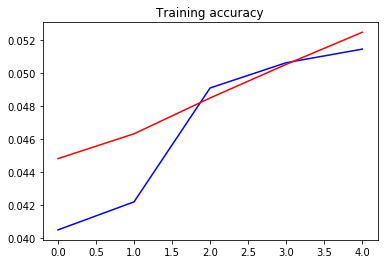

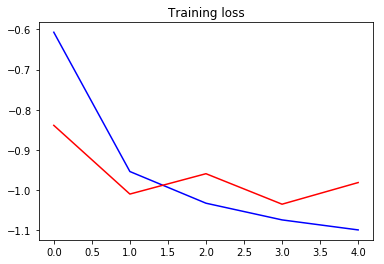

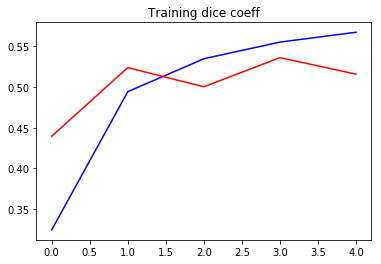

<Figure size 432x288 with 0 Axes>

In [23]:
# loss: -1.0319 - dice_coeff: 0.5650 - acc: 0.9551
# val_loss: -0.9757 - val_dice_coeff: 0.5386 - val_acc: 0.9611

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r-')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'b-')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)

In [24]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.98,1.02], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.01, height_shift_range=0.025,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


132/473 [=======>......................] - ETA: 40:07 - loss: -1.5034 - dice_coeff: 0.7639 - acc: 0.07 - ETA: 27:38 - loss: -1.3860 - dice_coeff: 0.7063 - acc: 0.06 - ETA: 26:42 - loss: -1.3605 - dice_coeff: 0.6979 - acc: 0.08 - ETA: 26:16 - loss: -1.1623 - dice_coeff: 0.5997 - acc: 0.06 - ETA: 25:53 - loss: -1.1265 - dice_coeff: 0.5810 - acc: 0.05 - ETA: 25:51 - loss: -1.1004 - dice_coeff: 0.5677 - acc: 0.05 - ETA: 25:43 - loss: -1.0928 - dice_coeff: 0.5636 - acc: 0.05 - ETA: 25:32 - loss: -1.1021 - dice_coeff: 0.5681 - acc: 0.05 - ETA: 25:23 - loss: -1.0774 - dice_coeff: 0.5559 - acc: 0.05 - ETA: 25:12 - loss: -1.1059 - dice_coeff: 0.5701 - acc: 0.05 - ETA: 24:30 - loss: -1.1302 - dice_coeff: 0.5820 - acc: 0.05 - ETA: 23:58 - loss: -1.1496 - dice_coeff: 0.5913 - acc: 0.05 - ETA: 23:30 - loss: -1.1591 - dice_coeff: 0.5963 - acc: 0.05 - ETA: 23:06 - loss: -1.1453 - dice_coeff: 0.5894 - acc: 0.05 - ETA: 22:39 - loss: -1.1738 - dice_coeff: 0.6034 - acc: 0.05 - ETA: 22:16 - loss: -1.1728 

264/473 [===============>..............] - ETA: 13:45 - loss: -1.1357 - dice_coeff: 0.5836 - acc: 0.04 - ETA: 13:42 - loss: -1.1372 - dice_coeff: 0.5844 - acc: 0.04 - ETA: 13:39 - loss: -1.1374 - dice_coeff: 0.5845 - acc: 0.04 - ETA: 13:37 - loss: -1.1350 - dice_coeff: 0.5834 - acc: 0.04 - ETA: 13:34 - loss: -1.1355 - dice_coeff: 0.5836 - acc: 0.04 - ETA: 13:32 - loss: -1.1371 - dice_coeff: 0.5845 - acc: 0.04 - ETA: 13:29 - loss: -1.1362 - dice_coeff: 0.5840 - acc: 0.04 - ETA: 13:27 - loss: -1.1340 - dice_coeff: 0.5829 - acc: 0.04 - ETA: 13:24 - loss: -1.1332 - dice_coeff: 0.5826 - acc: 0.04 - ETA: 13:22 - loss: -1.1313 - dice_coeff: 0.5816 - acc: 0.04 - ETA: 13:19 - loss: -1.1321 - dice_coeff: 0.5820 - acc: 0.04 - ETA: 13:17 - loss: -1.1298 - dice_coeff: 0.5811 - acc: 0.04 - ETA: 13:14 - loss: -1.1299 - dice_coeff: 0.5812 - acc: 0.04 - ETA: 13:11 - loss: -1.1277 - dice_coeff: 0.5802 - acc: 0.04 - ETA: 13:09 - loss: -1.1280 - dice_coeff: 0.5803 - acc: 0.04 - ETA: 13:06 - loss: -1.1282 

396/473 [========================>.....] - ETA: 8:20 - loss: -1.1277 - dice_coeff: 0.5808 - acc: 0.051 - ETA: 8:18 - loss: -1.1272 - dice_coeff: 0.5805 - acc: 0.051 - ETA: 8:15 - loss: -1.1284 - dice_coeff: 0.5811 - acc: 0.051 - ETA: 8:13 - loss: -1.1284 - dice_coeff: 0.5811 - acc: 0.051 - ETA: 8:10 - loss: -1.1292 - dice_coeff: 0.5814 - acc: 0.051 - ETA: 8:08 - loss: -1.1285 - dice_coeff: 0.5811 - acc: 0.051 - ETA: 8:06 - loss: -1.1280 - dice_coeff: 0.5809 - acc: 0.051 - ETA: 8:03 - loss: -1.1277 - dice_coeff: 0.5807 - acc: 0.051 - ETA: 8:01 - loss: -1.1264 - dice_coeff: 0.5800 - acc: 0.051 - ETA: 7:58 - loss: -1.1256 - dice_coeff: 0.5797 - acc: 0.051 - ETA: 7:56 - loss: -1.1253 - dice_coeff: 0.5796 - acc: 0.051 - ETA: 7:54 - loss: -1.1243 - dice_coeff: 0.5792 - acc: 0.051 - ETA: 7:51 - loss: -1.1251 - dice_coeff: 0.5796 - acc: 0.051 - ETA: 7:49 - loss: -1.1260 - dice_coeff: 0.5800 - acc: 0.051 - ETA: 7:46 - loss: -1.1260 - dice_coeff: 0.5800 - acc: 0.051 - ETA: 7:44 - loss: -1.1262 -

473/473 [==============================] - ETA: 3:02 - loss: -1.1260 - dice_coeff: 0.5801 - acc: 0.052 - ETA: 2:59 - loss: -1.1267 - dice_coeff: 0.5805 - acc: 0.052 - ETA: 2:57 - loss: -1.1273 - dice_coeff: 0.5807 - acc: 0.052 - ETA: 2:55 - loss: -1.1276 - dice_coeff: 0.5809 - acc: 0.052 - ETA: 2:52 - loss: -1.1267 - dice_coeff: 0.5804 - acc: 0.052 - ETA: 2:50 - loss: -1.1267 - dice_coeff: 0.5805 - acc: 0.052 - ETA: 2:48 - loss: -1.1273 - dice_coeff: 0.5807 - acc: 0.052 - ETA: 2:45 - loss: -1.1279 - dice_coeff: 0.5810 - acc: 0.052 - ETA: 2:43 - loss: -1.1280 - dice_coeff: 0.5811 - acc: 0.052 - ETA: 2:40 - loss: -1.1280 - dice_coeff: 0.5811 - acc: 0.052 - ETA: 2:38 - loss: -1.1282 - dice_coeff: 0.5812 - acc: 0.052 - ETA: 2:35 - loss: -1.1286 - dice_coeff: 0.5814 - acc: 0.052 - ETA: 2:33 - loss: -1.1291 - dice_coeff: 0.5816 - acc: 0.052 - ETA: 2:31 - loss: -1.1294 - dice_coeff: 0.5818 - acc: 0.052 - ETA: 2:28 - loss: -1.1289 - dice_coeff: 0.5815 - acc: 0.052 - ETA: 2:26 - loss: -1.1281 -

132/473 [=======>......................] - ETA: 3:12 - loss: -0.8279 - dice_coeff: 0.4291 - acc: 0.026 - ETA: 3:14 - loss: -0.8554 - dice_coeff: 0.4503 - acc: 0.047 - ETA: 3:14 - loss: -0.9014 - dice_coeff: 0.4703 - acc: 0.041 - ETA: 3:13 - loss: -0.9456 - dice_coeff: 0.4941 - acc: 0.053 - ETA: 3:10 - loss: -0.9975 - dice_coeff: 0.5187 - acc: 0.052 - ETA: 3:09 - loss: -1.0702 - dice_coeff: 0.5530 - acc: 0.050 - ETA: 3:10 - loss: -1.1176 - dice_coeff: 0.5764 - acc: 0.054 - ETA: 3:09 - loss: -1.1174 - dice_coeff: 0.5755 - acc: 0.051 - ETA: 3:08 - loss: -1.1152 - dice_coeff: 0.5745 - acc: 0.050 - ETA: 3:08 - loss: -1.0715 - dice_coeff: 0.5529 - acc: 0.047 - ETA: 3:08 - loss: -1.0763 - dice_coeff: 0.5553 - acc: 0.048 - ETA: 3:09 - loss: -1.0492 - dice_coeff: 0.5419 - acc: 0.046 - ETA: 4:10 - loss: -1.0543 - dice_coeff: 0.5445 - acc: 0.047 - ETA: 5:42 - loss: -1.0746 - dice_coeff: 0.5539 - acc: 0.046 - ETA: 7:03 - loss: -1.0747 - dice_coeff: 0.5536 - acc: 0.045 - ETA: 8:04 - loss: -1.0848 -

264/473 [===============>..............] - ETA: 12:19 - loss: -1.1785 - dice_coeff: 0.6042 - acc: 0.04 - ETA: 12:17 - loss: -1.1783 - dice_coeff: 0.6041 - acc: 0.04 - ETA: 12:15 - loss: -1.1805 - dice_coeff: 0.6052 - acc: 0.04 - ETA: 12:13 - loss: -1.1817 - dice_coeff: 0.6058 - acc: 0.04 - ETA: 12:11 - loss: -1.1791 - dice_coeff: 0.6044 - acc: 0.04 - ETA: 12:09 - loss: -1.1779 - dice_coeff: 0.6039 - acc: 0.04 - ETA: 12:07 - loss: -1.1784 - dice_coeff: 0.6041 - acc: 0.04 - ETA: 12:06 - loss: -1.1786 - dice_coeff: 0.6043 - acc: 0.04 - ETA: 12:04 - loss: -1.1799 - dice_coeff: 0.6049 - acc: 0.04 - ETA: 12:02 - loss: -1.1804 - dice_coeff: 0.6051 - acc: 0.04 - ETA: 12:00 - loss: -1.1804 - dice_coeff: 0.6051 - acc: 0.04 - ETA: 11:58 - loss: -1.1804 - dice_coeff: 0.6050 - acc: 0.04 - ETA: 11:56 - loss: -1.1799 - dice_coeff: 0.6048 - acc: 0.04 - ETA: 11:54 - loss: -1.1804 - dice_coeff: 0.6050 - acc: 0.04 - ETA: 11:52 - loss: -1.1806 - dice_coeff: 0.6051 - acc: 0.04 - ETA: 11:50 - loss: -1.1794 

396/473 [========================>.....] - ETA: 7:43 - loss: -1.1690 - dice_coeff: 0.6002 - acc: 0.051 - ETA: 7:41 - loss: -1.1704 - dice_coeff: 0.6009 - acc: 0.051 - ETA: 7:39 - loss: -1.1690 - dice_coeff: 0.6002 - acc: 0.051 - ETA: 7:36 - loss: -1.1699 - dice_coeff: 0.6007 - acc: 0.051 - ETA: 7:34 - loss: -1.1699 - dice_coeff: 0.6007 - acc: 0.051 - ETA: 7:32 - loss: -1.1692 - dice_coeff: 0.6003 - acc: 0.051 - ETA: 7:30 - loss: -1.1690 - dice_coeff: 0.6002 - acc: 0.051 - ETA: 7:28 - loss: -1.1689 - dice_coeff: 0.6003 - acc: 0.051 - ETA: 7:25 - loss: -1.1680 - dice_coeff: 0.5998 - acc: 0.051 - ETA: 7:23 - loss: -1.1670 - dice_coeff: 0.5993 - acc: 0.051 - ETA: 7:21 - loss: -1.1669 - dice_coeff: 0.5993 - acc: 0.051 - ETA: 7:19 - loss: -1.1684 - dice_coeff: 0.6000 - acc: 0.051 - ETA: 7:17 - loss: -1.1677 - dice_coeff: 0.5996 - acc: 0.051 - ETA: 7:14 - loss: -1.1685 - dice_coeff: 0.6001 - acc: 0.051 - ETA: 7:12 - loss: -1.1686 - dice_coeff: 0.6001 - acc: 0.051 - ETA: 7:10 - loss: -1.1687 -

473/473 [==============================] - ETA: 2:50 - loss: -1.1543 - dice_coeff: 0.5934 - acc: 0.052 - ETA: 2:48 - loss: -1.1544 - dice_coeff: 0.5934 - acc: 0.052 - ETA: 2:46 - loss: -1.1544 - dice_coeff: 0.5935 - acc: 0.052 - ETA: 2:44 - loss: -1.1548 - dice_coeff: 0.5937 - acc: 0.052 - ETA: 2:41 - loss: -1.1551 - dice_coeff: 0.5938 - acc: 0.052 - ETA: 2:39 - loss: -1.1557 - dice_coeff: 0.5941 - acc: 0.052 - ETA: 2:37 - loss: -1.1548 - dice_coeff: 0.5937 - acc: 0.052 - ETA: 2:35 - loss: -1.1552 - dice_coeff: 0.5939 - acc: 0.052 - ETA: 2:32 - loss: -1.1550 - dice_coeff: 0.5938 - acc: 0.052 - ETA: 2:30 - loss: -1.1555 - dice_coeff: 0.5940 - acc: 0.052 - ETA: 2:28 - loss: -1.1553 - dice_coeff: 0.5940 - acc: 0.052 - ETA: 2:26 - loss: -1.1553 - dice_coeff: 0.5940 - acc: 0.052 - ETA: 2:23 - loss: -1.1555 - dice_coeff: 0.5940 - acc: 0.052 - ETA: 2:21 - loss: -1.1553 - dice_coeff: 0.5940 - acc: 0.052 - ETA: 2:19 - loss: -1.1557 - dice_coeff: 0.5941 - acc: 0.052 - ETA: 2:17 - loss: -1.1555 -

132/473 [=======>......................] - ETA: 3:12 - loss: -1.2605 - dice_coeff: 0.6502 - acc: 0.072 - ETA: 3:06 - loss: -1.0967 - dice_coeff: 0.5756 - acc: 0.070 - ETA: 3:09 - loss: -1.0585 - dice_coeff: 0.5543 - acc: 0.065 - ETA: 3:08 - loss: -1.0588 - dice_coeff: 0.5537 - acc: 0.064 - ETA: 3:09 - loss: -0.9656 - dice_coeff: 0.5074 - acc: 0.065 - ETA: 3:10 - loss: -1.0732 - dice_coeff: 0.5588 - acc: 0.069 - ETA: 3:09 - loss: -1.0366 - dice_coeff: 0.5393 - acc: 0.063 - ETA: 3:09 - loss: -1.0775 - dice_coeff: 0.5588 - acc: 0.061 - ETA: 3:08 - loss: -1.1186 - dice_coeff: 0.5780 - acc: 0.060 - ETA: 3:08 - loss: -1.1423 - dice_coeff: 0.5891 - acc: 0.059 - ETA: 3:07 - loss: -1.1204 - dice_coeff: 0.5780 - acc: 0.057 - ETA: 3:07 - loss: -1.1320 - dice_coeff: 0.5830 - acc: 0.055 - ETA: 4:09 - loss: -1.1152 - dice_coeff: 0.5745 - acc: 0.053 - ETA: 5:32 - loss: -1.1041 - dice_coeff: 0.5689 - acc: 0.053 - ETA: 6:49 - loss: -1.1206 - dice_coeff: 0.5767 - acc: 0.052 - ETA: 7:55 - loss: -1.1283 -

264/473 [===============>..............] - ETA: 12:13 - loss: -1.1517 - dice_coeff: 0.5922 - acc: 0.05 - ETA: 12:11 - loss: -1.1530 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 12:09 - loss: -1.1553 - dice_coeff: 0.5939 - acc: 0.05 - ETA: 12:08 - loss: -1.1558 - dice_coeff: 0.5941 - acc: 0.05 - ETA: 12:06 - loss: -1.1585 - dice_coeff: 0.5954 - acc: 0.05 - ETA: 12:04 - loss: -1.1579 - dice_coeff: 0.5952 - acc: 0.05 - ETA: 12:02 - loss: -1.1588 - dice_coeff: 0.5956 - acc: 0.05 - ETA: 12:00 - loss: -1.1586 - dice_coeff: 0.5954 - acc: 0.05 - ETA: 11:58 - loss: -1.1577 - dice_coeff: 0.5949 - acc: 0.05 - ETA: 11:56 - loss: -1.1580 - dice_coeff: 0.5951 - acc: 0.05 - ETA: 11:54 - loss: -1.1550 - dice_coeff: 0.5936 - acc: 0.05 - ETA: 11:52 - loss: -1.1552 - dice_coeff: 0.5937 - acc: 0.05 - ETA: 11:50 - loss: -1.1567 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 11:48 - loss: -1.1567 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 11:46 - loss: -1.1567 - dice_coeff: 0.5945 - acc: 0.05 - ETA: 11:44 - loss: -1.1579 

396/473 [========================>.....] - ETA: 7:40 - loss: -1.1575 - dice_coeff: 0.5952 - acc: 0.053 - ETA: 7:37 - loss: -1.1577 - dice_coeff: 0.5953 - acc: 0.053 - ETA: 7:35 - loss: -1.1585 - dice_coeff: 0.5957 - acc: 0.053 - ETA: 7:33 - loss: -1.1568 - dice_coeff: 0.5948 - acc: 0.053 - ETA: 7:31 - loss: -1.1558 - dice_coeff: 0.5943 - acc: 0.053 - ETA: 7:29 - loss: -1.1562 - dice_coeff: 0.5945 - acc: 0.053 - ETA: 7:27 - loss: -1.1549 - dice_coeff: 0.5939 - acc: 0.053 - ETA: 7:24 - loss: -1.1549 - dice_coeff: 0.5939 - acc: 0.053 - ETA: 7:22 - loss: -1.1552 - dice_coeff: 0.5940 - acc: 0.053 - ETA: 7:20 - loss: -1.1562 - dice_coeff: 0.5945 - acc: 0.053 - ETA: 7:18 - loss: -1.1570 - dice_coeff: 0.5949 - acc: 0.053 - ETA: 7:16 - loss: -1.1576 - dice_coeff: 0.5951 - acc: 0.053 - ETA: 7:13 - loss: -1.1584 - dice_coeff: 0.5955 - acc: 0.053 - ETA: 7:11 - loss: -1.1584 - dice_coeff: 0.5955 - acc: 0.053 - ETA: 7:09 - loss: -1.1583 - dice_coeff: 0.5956 - acc: 0.053 - ETA: 7:07 - loss: -1.1584 -

473/473 [==============================] - ETA: 2:49 - loss: -1.1673 - dice_coeff: 0.6000 - acc: 0.054 - ETA: 2:47 - loss: -1.1669 - dice_coeff: 0.5997 - acc: 0.054 - ETA: 2:45 - loss: -1.1679 - dice_coeff: 0.6002 - acc: 0.054 - ETA: 2:43 - loss: -1.1686 - dice_coeff: 0.6006 - acc: 0.054 - ETA: 2:40 - loss: -1.1681 - dice_coeff: 0.6003 - acc: 0.054 - ETA: 2:38 - loss: -1.1681 - dice_coeff: 0.6003 - acc: 0.054 - ETA: 2:36 - loss: -1.1685 - dice_coeff: 0.6005 - acc: 0.054 - ETA: 2:34 - loss: -1.1690 - dice_coeff: 0.6007 - acc: 0.054 - ETA: 2:31 - loss: -1.1685 - dice_coeff: 0.6005 - acc: 0.054 - ETA: 2:29 - loss: -1.1685 - dice_coeff: 0.6005 - acc: 0.054 - ETA: 2:27 - loss: -1.1683 - dice_coeff: 0.6004 - acc: 0.054 - ETA: 2:25 - loss: -1.1688 - dice_coeff: 0.6006 - acc: 0.054 - ETA: 2:22 - loss: -1.1689 - dice_coeff: 0.6007 - acc: 0.054 - ETA: 2:20 - loss: -1.1694 - dice_coeff: 0.6009 - acc: 0.054 - ETA: 2:18 - loss: -1.1686 - dice_coeff: 0.6005 - acc: 0.054 - ETA: 2:16 - loss: -1.1686 -

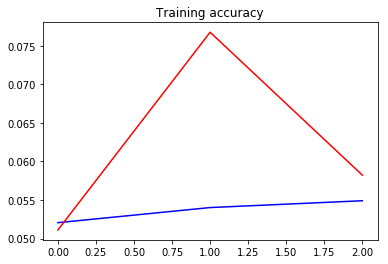

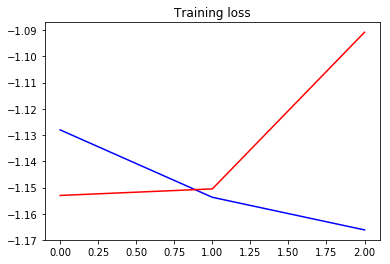

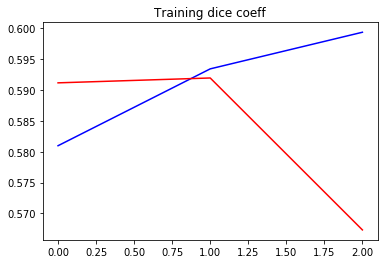

<Figure size 432x288 with 0 Axes>

In [25]:
plot_training(history)